**Заголовок:** 

Модель для поддержания активности постоянных клиетов интернет-магазина «В один клик»

**Цель исследования:** 

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность

**Ход исследования:**
1. Анализ информации о данных: загрузка и изучение общей информации из датасетов
2. Предобработка данных: обработка дубликатов и изменение типов данных
3. Исследовательский анализ данных: отбор клиентов с покупательской активностью не менее трёх месяцев
4. Объединение таблиц market_file.csv, market_money.csv и market_time.csv
5. Корреляционный анализ признаков в итоговой таблице
6. Использование пайплайнов:выбор лучшей модели
7. Анализ важности признаков
8. Сегментация покупателей: предложения по работе с сегментом для увеличения покупательской активности

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций

In [1]:
#загружаю библиотеки
!pip uninstall numpy pandas scipy matplotlib seaborn numba -y -q
!pip install numpy==1.22.4 pandas==1.4.3 scipy==1.9.0 matplotlib seaborn scikit-learn phik shap numba -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
from phik import phik_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import shap

## Загрузка данных

In [2]:
#открываю данные
df_market_file = pd.read_csv('/datasets/market_file.csv', sep=',') #данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
df_market_money = pd.read_csv('/datasets/market_money.csv', sep=',') #сколько покупатель всего потратил за период взаимодействия с сайтом
df_market_time = pd.read_csv('/datasets/market_time.csv', sep=',') #время (в минутах), которое покупатель провёл на сайте в течение периода
df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',') #среднемесячной прибыли продавца за последние 3 месяца от продаж каждому покупателю

In [3]:
df_market_file.info() #общая информация о данных о поведении покупателя на сайте

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [4]:
df_market_file.head() #вывожу первые строки

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
df_market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


В данных df_market_file 1300 строк. Пропуски отсутствуют. Названия некоторых столбцов содержат пробелы, что нужно будет исправить в дальнейшем

In [6]:
df_market_money.info() #общая информация о том, сколько покупатель всего потратил за период взаимодействия с сайтом

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [7]:
df_market_money.head() #вывожу первые строки

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
df_market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


В данных df_market_money 3900 строк. Пропуски отсутствуют. Вероятно есть выбросы, так как максимальные и минимальные значения сильно отличаются от квартилей, вдальнейшем построю графики и разбирусь с этим

In [9]:
df_market_time.info() #общая информация о времени (в минутах), которое покупатель провёл на сайте в течение периода

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
df_market_time.head() #вывожу первые строки

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [11]:
df_market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


В данных df_market_time 2600 строк. Пропуски отсутствуют. В периоде есть опечатки, нужно будет исправить

In [12]:
df_money.info() #общая информация о среднемесячной прибыли продавца за последние 3 месяца от продаж каждому покупателю

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [13]:
df_money.head() #вывожу первые строки

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [14]:
df_money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


В данных df_market_time 1300 строк. Пропуски отсутствуют

**Выводы:** 
1. В данных df_market_file 1300 строк. Пропуски отсутствуют. Названия некоторых столбцов содержат пробелы, что нужно будет исправить в дальнейшем
2. В данных df_market_money 3900 строк. Пропуски отсутствуют. Вероятно есть выбросы, так как максимальные и минимальные значения сильно отличаются от квартилей
3. В данных df_market_time 2600 строк. Пропуски отсутствуют. В периоде есть опечатки, нужно будет исправить
4. В данных df_market_time 1300 строк. Пропуски отсутствуют

##  Предобработка данных

**Переименование столбцов**

В описании проекта сказано, что названия столбцов можно оставить кириллическими, поэтому заменим пробелы на подчеркивания и приведем к нижнему регистру

In [15]:
def columns_remove_spaces(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()

In [16]:
columns_remove_spaces(df_market_file)
columns_remove_spaces(df_market_money)
columns_remove_spaces(df_market_time)
columns_remove_spaces(df_money)

In [17]:
print(df_market_file.columns)
print(df_market_money.columns)
print(df_market_time.columns)
print(df_money.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


**Поиск дубликатов**

In [18]:
#исследую данные на наличие явных дубликатов
print('Количество явных дубликатов в "df_market_file" = ', df_market_file.duplicated().sum())
print('Количество явных дубликатов в "df_market_money" = ', df_market_money.duplicated().sum())
print('Количество явных дубликатов в "df_market_time" = ', df_market_time.duplicated().sum())
print('Количество явных дубликатов в "df_money" = ', df_money.duplicated().sum())

Количество явных дубликатов в "df_market_file" =  0
Количество явных дубликатов в "df_market_money" =  0
Количество явных дубликатов в "df_market_time" =  0
Количество явных дубликатов в "df_money" =  0


In [19]:
df_market_file[df_market_file.duplicated(subset=['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'])]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
547,215895,Снизилась,стандарт,нет,4.4,5,517,0.23,Товары для детей,1,2,5,11
548,215896,Снизилась,стандарт,нет,4.3,4,460,0.16,Техника для красоты и здоровья,2,1,3,6
549,215897,Снизилась,стандарт,да,3.9,4,627,0.24,Товары для детей,3,3,7,8
550,215898,Снизилась,стандарт,да,5.5,4,703,0.14,Мелкая бытовая техника и электроника,2,1,3,7
551,215899,Снизилась,стандарт,нет,5.0,4,136,0.27,Товары для детей,3,4,4,17
552,215900,Снизилась,стандарт,да,4.8,4,907,0.30,Косметика и аксесуары,2,1,1,6
553,215901,Снизилась,стандарт,нет,3.9,5,600,0.17,Домашний текстиль,1,7,4,10
554,215902,Снизилась,стандарт,да,3.3,3,871,0.20,Техника для красоты и здоровья,2,4,2,17
555,215903,Снизилась,стандарт,да,5.6,5,574,0.28,Домашний текстиль,3,2,3,9
556,215904,Снизилась,премиум,да,5.5,5,982,0.94,Мелкая бытовая техника и электроника,3,1,8,10


Если исключить id, то обнаруживается 11 дубликатов. Не считаю целесообразным их удалять

Явных дубликатов не обнаружено

**Анализ уникальных наименований**

In [20]:
print(f'Уникальные значения для покупательской активности:{df_market_file["покупательская_активность"].unique()}')
print(f'Уникальные значения для типа сервиса:{df_market_file["тип_сервиса"].unique()}')
print(f'Уникальные значения для разрешения сообщений:{df_market_file["разрешить_сообщать"].unique()}')
print(f'Уникальные значения для популярной категории:{df_market_file["популярная_категория"].unique()}')
print(f'Уникальные значения для периода:{df_market_money["период"].unique()}, {df_market_time["период"].unique()}')

Уникальные значения для покупательской активности:['Снизилась' 'Прежний уровень']
Уникальные значения для типа сервиса:['премиум' 'стандартт' 'стандарт']
Уникальные значения для разрешения сообщений:['да' 'нет']
Уникальные значения для популярной категории:['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
Уникальные значения для периода:['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц'], ['текущий_месяц' 'предыдцщий_месяц']


In [21]:
#привожу значения к единообразию
df_market_file["тип_сервиса"] = df_market_file["тип_сервиса"].replace({'стандартт': 'стандарт'})
df_market_time["период"] = df_market_time["период"].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
df_market_file["популярная_категория"] = df_market_file["популярная_категория"].replace({'Косметика и аксесуары': 'Косметика и аксессуары'})
#проверяю изменения
print(f'Уникальные значения для типа сервиса:{df_market_file["тип_сервиса"].unique()}')
print(f'Уникальные значения для периода:{df_market_time["период"].unique()}')
print(f'Уникальные значения для популярной категории:{df_market_file["популярная_категория"].unique()}')

Уникальные значения для типа сервиса:['премиум' 'стандарт']
Уникальные значения для периода:['текущий_месяц' 'предыдущий_месяц']
Уникальные значения для популярной категории:['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


**Выводы:**

В ходе предобработки данных в датафреймах сделаны следующие преобразования:
1. Названия столбцов во всех датасетах приведены к единому формату
2. В столбцах тип_сервиса и период значения приведены к единому образцу

##  Исследовательский анализ данных

**Статистический анализ признаков**

In [24]:
def plot_numeric_features(df):
    for column in df.columns:
        if column != 'id':
            # проверяю, является ли признак дискретным или непрерывным
            if pd.api.types.is_integer_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):
                # столбчатая диаграмма для дискретных признаков
                plt.figure(figsize=(8, 4))
                sns.countplot(x=df[column], color='blue')
                plt.title(f'Столбчатая диаграмма {column}')
                plt.xlabel(column)
                plt.ylabel('Частота')
                plt.grid(axis='y', alpha=0.75)
                plt.show()
            elif pd.api.types.is_numeric_dtype(df[column]):
                # гистограмма для непрерывных признаков
                plt.figure(figsize=(8, 4))
                plt.hist(df[column], bins=10, alpha=0.5, color='blue')
                plt.title(f'Гистограмма {column}')
                plt.xlabel(column)
                plt.ylabel('Частота')
                plt.grid(axis='y', alpha=0.75)
                plt.show()

                # ящик с усами для непрерывных признаков
                plt.figure(figsize=(8, 4))
                plt.boxplot(df[column])
                plt.title(f'Ящик с усами {column}')
                plt.ylabel(column)
                plt.grid(axis='y', alpha=0.75)
                plt.show()

In [25]:
#создаю функцию для визуализации категориальных признаков
def plot_categorical_features(df):
    for column in df.columns:
        plt.figure(figsize=(14, 6))  # Размер фигуры увеличен для лучшего представления графиков

        if pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
            category_counts = df[column].value_counts()

            # Столбчатая диаграмма
            plt.subplot(1, 2, 1)
            category_counts.plot(kind='bar', alpha=0.7, color='orange')
            plt.title(f'Частота категорий в {column}')
            plt.xlabel(column)
            plt.ylabel('Количество')
            plt.xticks(rotation=45, ha='right')  # Поворот и выравнивание меток по оси x
            plt.grid(axis='y', alpha=0.75)

            # Круговая диаграмма с процентами
            plt.subplot(1, 2, 2)
            plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90,
                    colors=plt.cm.tab20.colors, textprops={'fontsize': 10})  # Увеличение шрифта текста
            plt.title(f'Распределение {column} (круговая диаграмма)')
            plt.axis('equal')

            plt.tight_layout()  # Регулировка отступов между подграфиками
            plt.show()

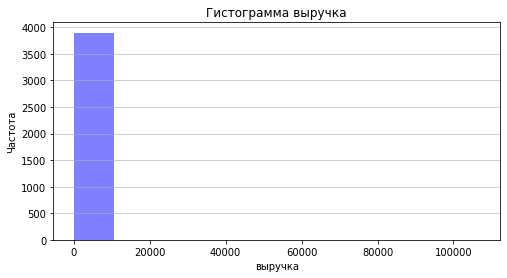

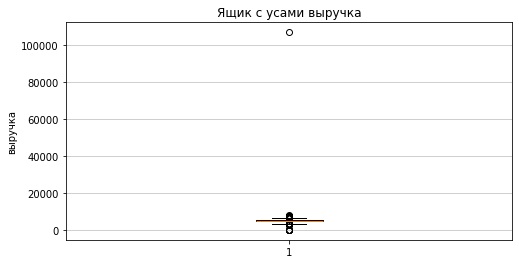

In [26]:
# визуализирую количественные признаки df_market_money
plot_numeric_features(df_market_money)

Есть выброс. Заменяю его на медианное значение

In [27]:
median_value = df_market_money['выручка'].median()

# заменяю выброс
df_market_money['выручка'] = df_market_money['выручка'].apply(
    lambda x: median_value if x > 10000 else x
)

df_market_money['выручка'].describe()

count    3900.000000
mean     4999.566641
std       706.909531
min         0.000000
25%      4590.150000
50%      4957.250000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

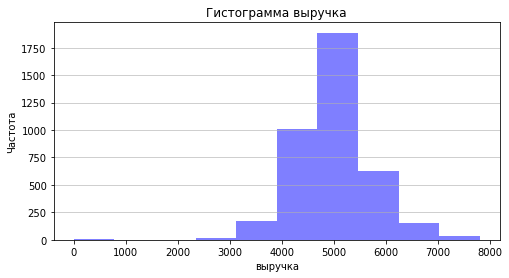

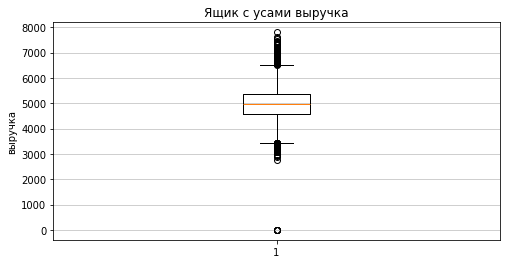

In [28]:
plot_numeric_features(df_market_money)

Видно, что не все покупатели были активны в течение последних трех месяцев. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

In [29]:
values = df_market_money[df_market_money['выручка'] == 0]['id'].unique()
df_market_money_aktiv = df_market_money[df_market_money['id'].isin(values) == False ]
money_small = df_market_money[df_market_money['выручка'] == 0]['id'].nunique()
money_big = df_market_money_aktiv['id'].nunique()
print(f'Общее количество клиентов - ', df_market_money['id'].nunique())
print(f'Количество клиентов с активностью не менее трех месяцев -', df_market_money_aktiv['id'].nunique())

Общее количество клиентов -  1300
Количество клиентов с активностью не менее трех месяцев - 1297


Далее в исследовании будем работать с этими клиентами.

In [30]:
df_market_file = df_market_file[df_market_file['id'].isin(values) == False ]
print(f'Общее количество активных клиентов - ', df_market_file['id'].nunique())

df_market_money = df_market_money_aktiv
print(f'Общее количество активных клиентов - ', df_market_money['id'].nunique())

df_market_time = df_market_time[df_market_time['id'].isin(values) == False ]
print(f'Общее количество активных клиентов - ', df_market_time['id'].nunique())

df_money = df_money[df_money['id'].isin(values) == False ]
print(f'Общее количество активных клиентов - ', df_money['id'].nunique())

Общее количество активных клиентов -  1297
Общее количество активных клиентов -  1297
Общее количество активных клиентов -  1297
Общее количество активных клиентов -  1297


<Figure size 1008x432 with 0 Axes>

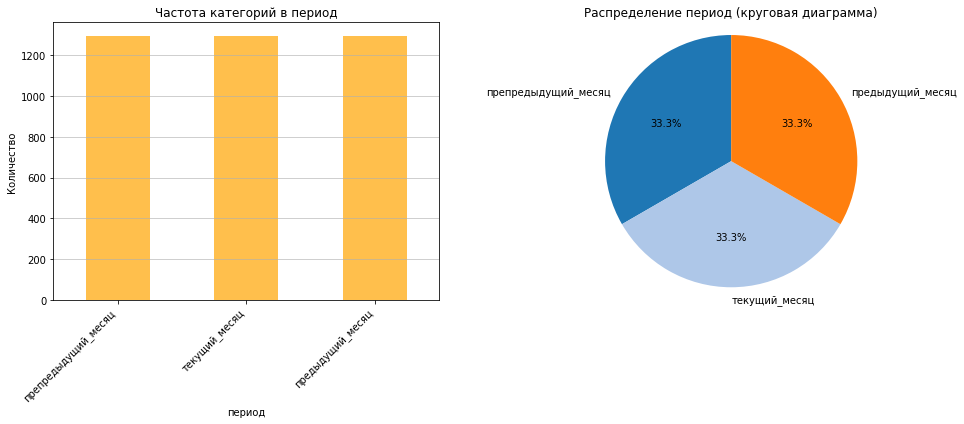

<Figure size 1008x432 with 0 Axes>

In [31]:
# визуализирую категориальные признаки df_market_money
plot_categorical_features(df_market_money)

In [32]:
display(df_market_money.pivot_table(index='период', values=['выручка'], aggfunc='sum'))

,выручка
период,
предыдущий_месяц,6417996.5
препредыдущий_месяц,6272769.0
текущий_месяц,6793530.0


Выручка за последние три месяца примерно одинаковая

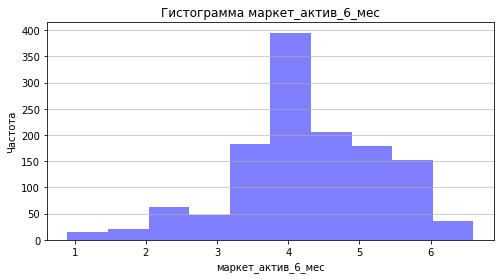

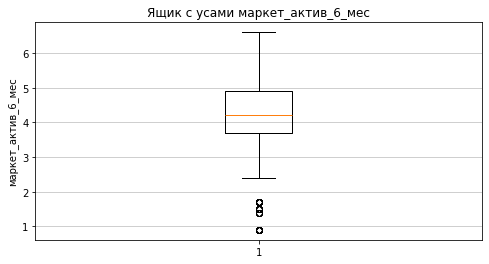

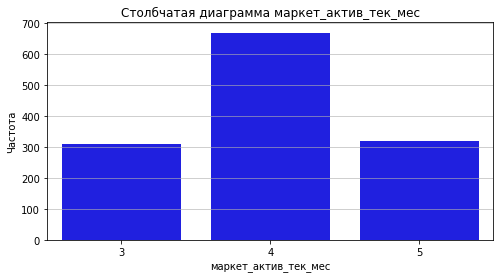

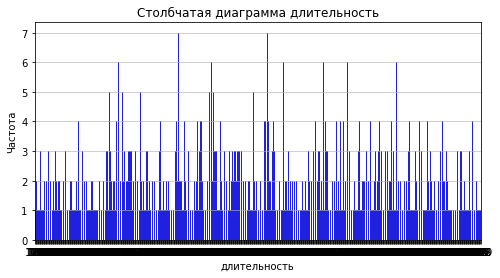

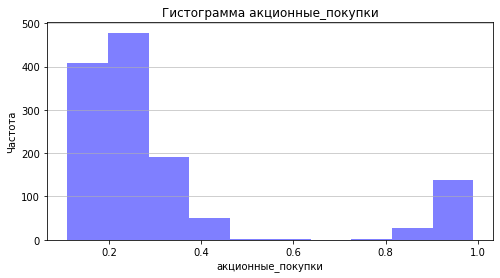

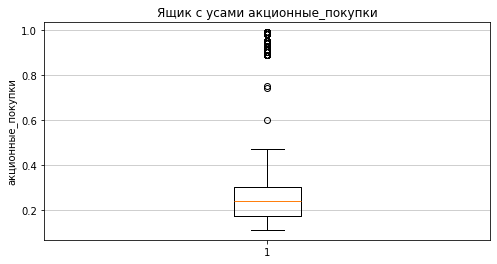

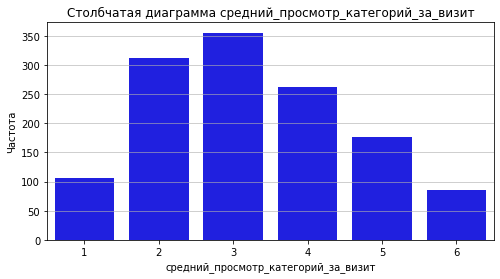

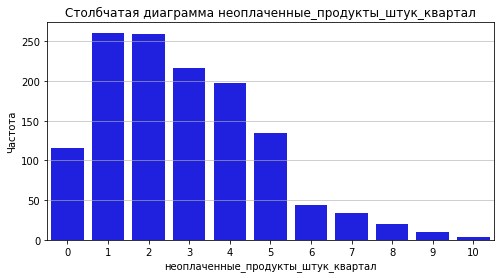

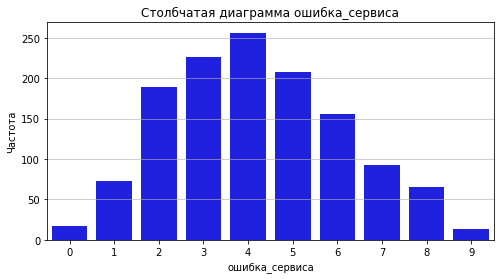

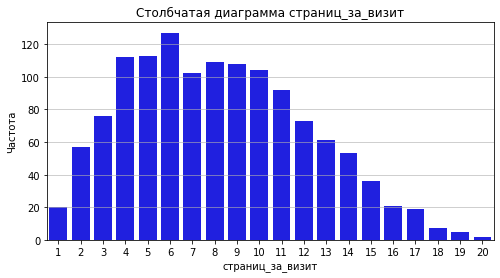

In [33]:
# визуализирую количественные признаки df_market_file
plot_numeric_features(df_market_file)

Большинство покупателей не ориентируются на скидки. Но часть клиентов отлеживают скидки. Поэтому подготовке данных для модели нужно превратить колонку акционные_покупки в категоральный признак.
Возможно, стоит поработать над стабильностью работы сайта. В среднем 4 разаза визит возникает ошибка сервиса.

<Figure size 1008x432 with 0 Axes>

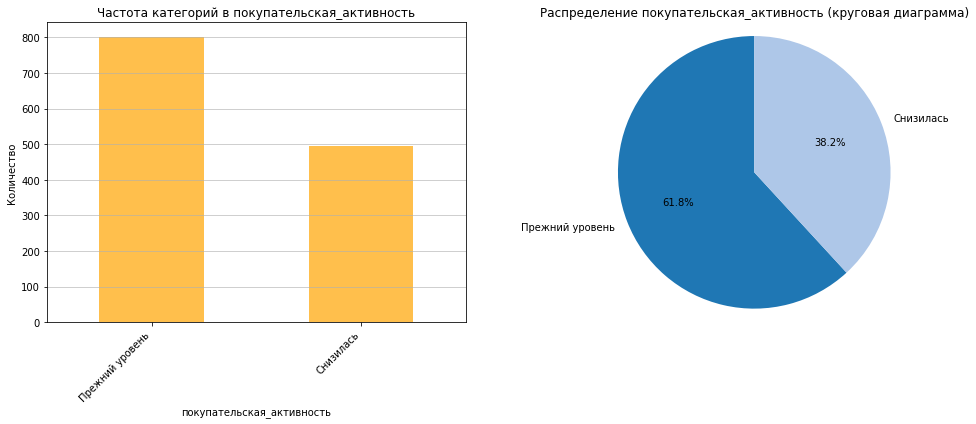

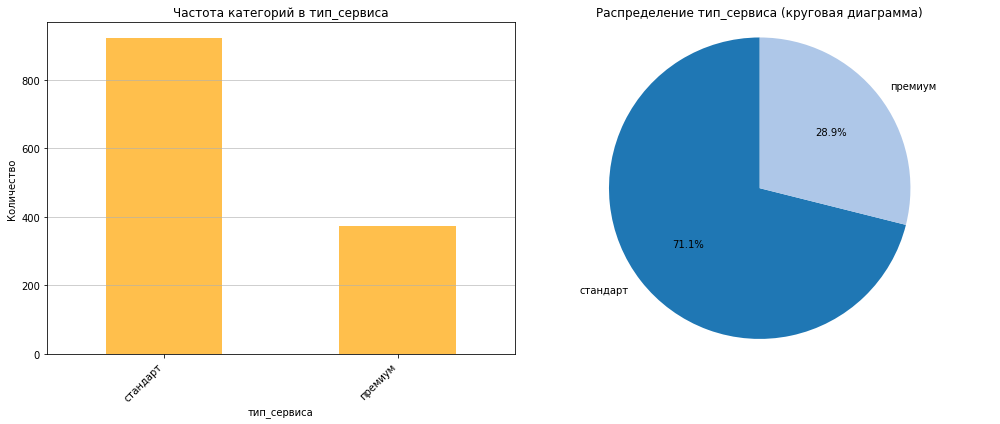

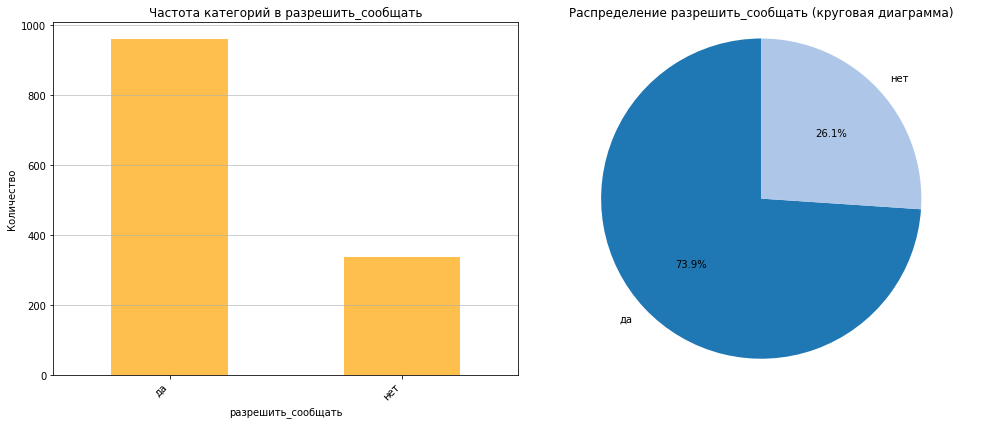

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

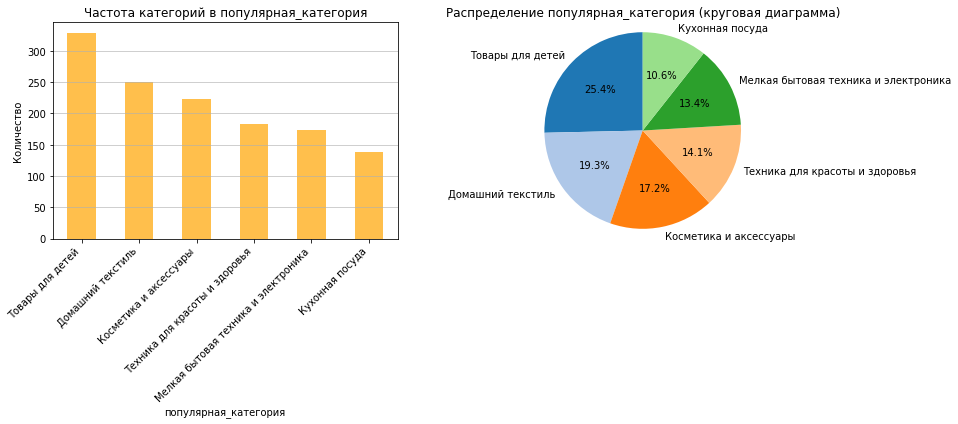

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

In [34]:
# визуализирую категориальные признаки df_market_file
plot_categorical_features(df_market_file)

<div class="alert alert-warning">
<b>Комментарий 👉</b>

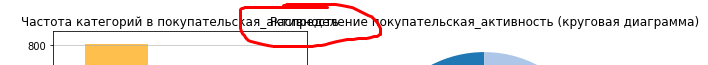
</div>

Видно дисбаланс значений в целевом признаке, это нужно будет учесть в модели
Большинство клиентов (71,1%) пользуются типом сервиса стандарт
Самымой популярной категорией являются товары для детей, наименее популярной - кухонная посуда

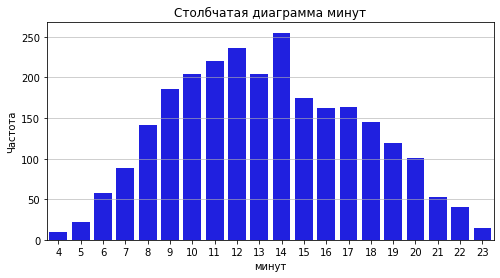

In [35]:
# визуализирую количественные признаки df_market_time
plot_numeric_features(df_market_time)

Половина покупателей проводят на сайте от 10 до 16 минут.

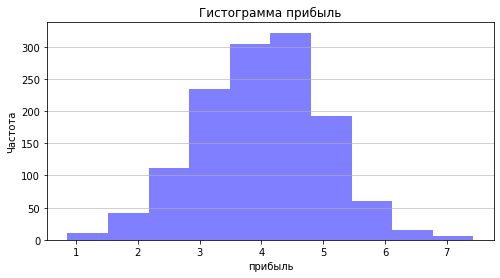

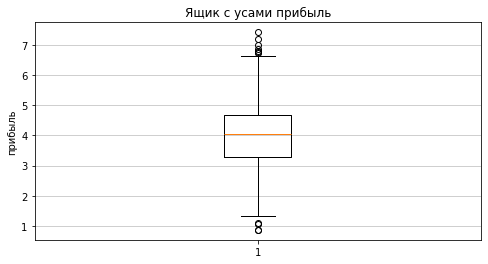

In [36]:
# визуализирую количественные признаки df_money
plot_numeric_features(df_money)

**Выводы:**
1. В df_market_money один выброс был заменен на медианное занчение.
2. Трое из 1300 покупателей не были активны в течение трех месяцев. Поэтому данные по ним исключены из анализа.
3. Выручка за последние три месяца примерно одинаковая
4. Большинство покупателей не ориентируются на скидки. Но часть клиентов отлеживают скидки. Поэтому подготовке данных для модели нужно превратить колонку акционные_покупки в категоральный признак.
5. Возможно, стоит поработать над стабильностью работы сайта. В среднем 4 разаза визит возникает ошибка сервиса.
6. Видно дисбаланс значений в целевом признаке, это нужно будет учесть в модели
7. Большинство клиентов (71,1%) пользуются типом сервиса стандарт
8. Самымой популярной категорией являются товары для детей, наименее популярной - кухонная посуда
9. Половина покупателей проводят на сайте от 10 до 16 минут.

## Объединение таблиц

Объединяю данные из датафреймов df_market_file, df_market_money, df_market_time в одну таблицу

In [37]:
df_market_money.head()

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


In [38]:
# df_market_money['выручка_текущий_месяц'] = df_market_money.loc[df_market_money['период'] == 'текущий_месяц', 'выручка']
# df_market_money['выручка_предыдущий_месяц'] = df_market_money.loc[df_market_money['период'] == 'предыдущий_месяц', 'выручка']   
# df_market_money['выручка_препредыдущий_месяц'] = df_market_money.loc[df_market_money['период'] == 'препредыдущий_месяц', 'выручка']   
# drop_columns=['период', 'выручка']
# df_market_money= df_market_money.drop(drop_columns, axis =1)
# df_market_money = df_market_money.groupby('id') .agg ({'выручка_текущий_месяц':'first', 'выручка_предыдущий_месяц':'first',
#                                                  'выручка_препредыдущий_месяц':'first' })
# df_market_money.head()

In [39]:
# извлекаю выручку для текущего, предыдущего и препредыдущего месяцев,
# фильтруя данные по соответствующему 'периоду'
df_market_money['выручка_текущий_месяц'] = df_market_money.loc[
    df_market_money['период'] == 'текущий_месяц', 'выручка'
]

df_market_money['выручка_предыдущий_месяц'] = df_market_money.loc[
    df_market_money['период'] == 'предыдущий_месяц', 'выручка'
]

df_market_money['выручка_препредыдущий_месяц'] = df_market_money.loc[
    df_market_money['период'] == 'препредыдущий_месяц', 'выручка'
]

# удаляю ненужные колонки ('период' и 'выручка')
drop_columns = ['период', 'выручка']
df_market_money = df_market_money.drop(drop_columns, axis=1)

# группирую данные по 'id' и агрегирую выручку по месяцам,
# выбирая первую (единственную) запись для каждого 'id'
df_market_money = df_market_money.groupby('id').agg({
    'выручка_текущий_месяц': 'first',
    'выручка_предыдущий_месяц': 'first',
    'выручка_препредыдущий_месяц': 'first'
})

df_market_money.head()

,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц
id,,,
215349,4971.6,5216.0,4472.0
215350,5058.4,5457.5,4826.0
215351,6610.4,6158.0,4793.0
215352,5872.5,5807.5,4594.0
215353,5388.5,4738.5,5124.0


In [40]:
df_market_time['период_текущий_месяц'] = df_market_time.loc[df_market_time['период'] == 'текущий_месяц', 'минут']
df_market_time['период_предыдущий_месяц'] = df_market_time.loc[df_market_time['период'] == 'предыдущий_месяц', 'минут']
drop_columns=['период', 'минут']
df_market_time= df_market_time.drop(drop_columns, axis =1)
df_market_time = df_market_time.groupby('id') .agg ({'период_текущий_месяц':'first', 'период_предыдущий_месяц':'first'})

df_market_time.head()

,период_текущий_месяц,период_предыдущий_месяц
id,,
215349,10.0,12.0
215350,13.0,8.0
215351,13.0,11.0
215352,11.0,8.0
215353,10.0,10.0


In [41]:
data = pd.merge(pd.merge(df_market_file, df_market_money, on='id'), df_market_time, on='id')
data = data.set_index('id')
display(data.head())

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,период_текущий_месяц,период_предыдущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10.0,12.0
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13.0,8.0
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13.0,11.0
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11.0,8.0
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10.0,10.0


In [42]:
data.shape

(1297, 17)

**Выводы:**

После объединения таблиц все данные находятся в одном датасете

## Корреляционный анализ

Провожу корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования

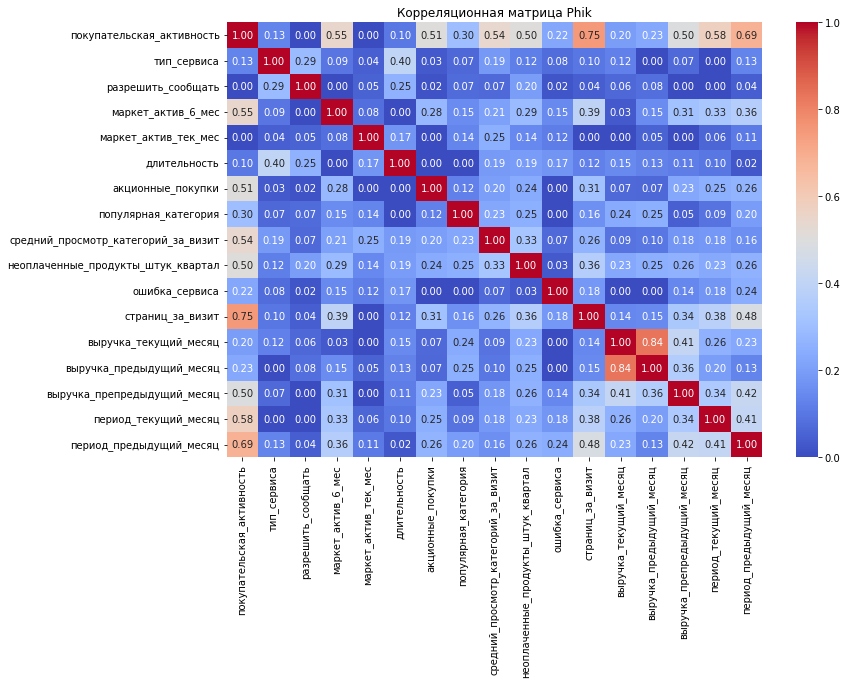

In [44]:
interval_columns = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит', 
    'выручка_текущий_месяц', 
    'выручка_предыдущий_месяц', 
    'выручка_препредыдущий_месяц', 
    'период_текущий_месяц', 
    'период_предыдущий_месяц'
]

# вычисление матрицы корреляции с методом Phik
phik_matrix_result = data.phik_matrix(interval_cols=interval_columns)

# визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix_result, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10})
plt.title('Корреляционная матрица Phik')
plt.show()

Целевой признак, связанный с покупательской активностью, имеет корреляцию с количеством страниц, которые клиенты просматривают за один визит, а также с временем, проведённым в предыдущем и текущем месяце. Из всех признаков наблюдается лишь одна относительно сильная корреляция между выручкой за предыдущий месяц и текущим месяцем, однако коэффициент корреляции составляет менее 0.9, что означает, что нет необходимости удалять эти признаки.

## Использование пайплайнов

Приступаю к построению модели. Переберу модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(), используя пайплайны.

Подготовлю данные. Закодирую целевой признак в значение 0 и 1. Колонку Акционные_покупки превращаю в категоральный признак. id сделаю индексами

In [45]:
# data['покупательская_активность'] = data['покупательская_активность'].apply( lambda x: 1 if x=='Снизилась' else 0 )
# data['покупательская_активность'] = data['покупательская_активность'].astype(int)

In [46]:
# cоздаю экземпляр LabelEncoder
le = LabelEncoder()

# кодирую целевой признак
data['покупательская_активность'] = le.fit_transform(data['покупательская_активность'])

# меняю метки местами
inverted_target = 1 - data['покупательская_активность']

print("Измененные классы целевой переменной:", inverted_target.values)

Измененные классы целевой переменной: [0 0 0 ... 1 1 1]


In [47]:
data['акционные_покупки'] = data['акционные_покупки'].apply( lambda x: 'часто покупает по акции' if x>= 0.5 else 'редко покупает по акции' )

In [48]:
display(data.head())

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,период_текущий_месяц,период_предыдущий_месяц
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,часто покупает по акции,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10.0,12.0
215350,1,стандарт,нет,4.9,3,539,редко покупает по акции,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13.0,8.0
215351,1,стандарт,да,3.2,5,896,часто покупает по акции,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13.0,11.0
215352,1,стандарт,нет,5.1,3,1064,часто покупает по акции,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11.0,8.0
215353,1,стандарт,да,3.3,4,762,редко покупает по акции,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10.0,10.0


Проверяю наличие дисбаланса классов

In [49]:
data['покупательская_активность'].value_counts(normalize=True)

0    0.61835
1    0.38165
Name: покупательская_активность, dtype: float64

Нужно провести стратификацию данных при их подготовке

In [50]:
RANDOM_STATE=42

X = data.drop(['покупательская_активность'], axis=1)
y = data['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25, 
    random_state = RANDOM_STATE,
    stratify = y)

In [51]:
print("Размерности выборок:")
print("Тренировочная выборка (X_train):", X_train.shape)
print("Тестовая выборка (X_test):", X_test.shape)

Размерности выборок:
Тренировочная выборка (X_train): (972, 16)
Тестовая выборка (X_test): (325, 16)


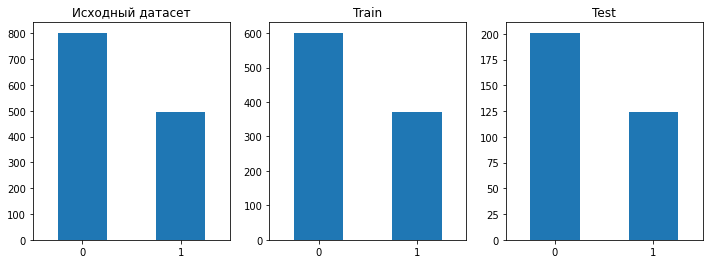

In [52]:
# визуализация баланса целевого признака в выборках
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

y.value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title("Исходный датасет")
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title("Train")
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0)
ax[2].set_title("Test")

plt.show()

Начинаю собирать пайплайн:

In [53]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория', 'тип_сервиса']
ord_columns = ['акционные_покупки']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'маркет_актив_тек_мес', 
               'длительность', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_текущий_месяц',
               'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'период_текущий_месяц', 
               'период_предыдущий_месяц']

In [55]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ]
)

In [56]:
# cоздаю пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['редко покупает по акции','часто покупает по акции']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [57]:
# создаю общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Объединила этапы подготовки данных, применяя пайплайны ohe_pipe и ord_pipe. Данные в числовых столбцах, обозначенных как num_columns, а также в столбцах minmax_columns подверглись масштабированию. В соответствии с условиями задачи использовала два кодировщика и два скейлера.

In [58]:
# создаю итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [59]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Наиболее подходящей метрикой для нашей задачи является roc-auc. Она демонстрирует связь между истинно положительными (TPR) и ложными положительными (FPR) наблюдениями, благодаря чему всегда предоставляет адекватную оценку качества модели. В отличие от этого, метрика F1 может указывать на низкое качество, если хотя бы одна из её составляющих показывает плохие результаты. Что касается accuracy, эта метрика учитывает лишь общее количество правильных предсказаний, не обращая внимания на то, как модель работает с минорными классами. Поэтому использовать её в условиях дисбаланса классов нецелесообразно

In [60]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория',
                                                                                'тип_сервиса']),...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [61]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория',
                                                   'тип_сервиса']),
                        

In [62]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


**Выводы:**

В результате анализа различных моделей с использованием пайплайнов наилучшей моделью оказалась линейная регрессия. Она обладает следующими характеристиками: значение параметра C равно 4, что указывает на умеренную регуляризацию — высокий параметр C позволяет модели лучше адаптироваться к данным, что в данном случае свидетельствует о относительно слабой регуляризации. Параметр penalty установлен на 'l1', что подразумевает использование L1-регуляризации, которая добавляет штраф за абсолютные значения коэффициентов модели во время процесса обучения. Это способствует отбору значимых признаков, приводя к тому, что менее важные параметры могут быть обнулены. Также фиксирован параметр random_state равным 42, что служит простой константой для обеспечения воспроизводимости результатов. Алгоритм оптимизации выбранный для обучения модели — 'liblinear', который хорошо подходит для задач двоичной классификации и эффективно справляется с средними и крупными наборами данных. Значение ROC AUC составило 0.92, что демонстрирует достаточно высокий уровень точности модели.

## Анализ важности признаков

Строю график общей значимости признаков:

In [63]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)
shap_values = explainer(X_test_2)

Строю график общей значимости признаков:

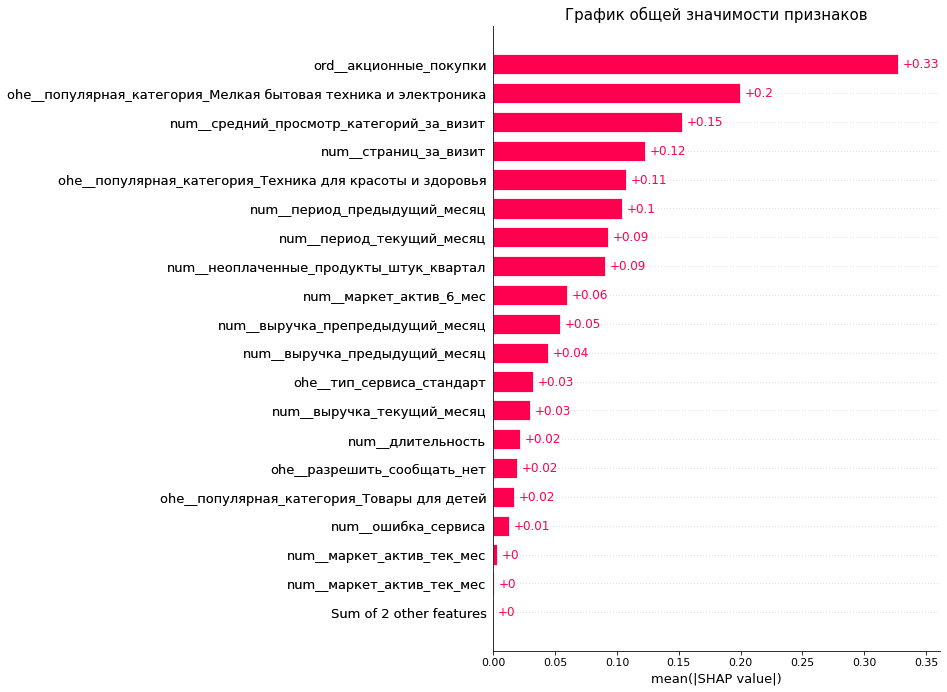

In [64]:
shap.plots.bar(shap_values, max_display=20, show=False)
plt.title('График общей значимости признаков', size=15)
plt.show()

Самыми важными признаками для построения модели были:

- акционные покупки;
- популярная категория;
- средний просмотр категорий за визит;
- страниц за визит;
- проведенное в прошлом месяце время.

Как признаки влияют на каждое предсказание модели:

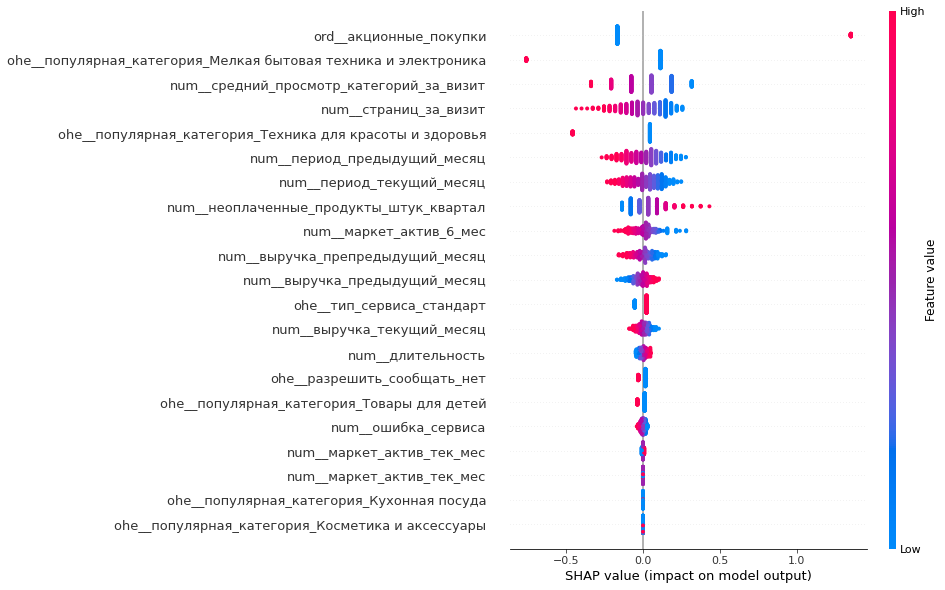

In [65]:
shap.plots.beeswarm(shap_values, max_display=25)

График демонстрирует общую важность признаков модели по значениям Шепли, которые были присвоены всем наблюдениям в выборке. На этом графике негативные значения Шепли, находящиеся слева от центральной вертикальной линии, указывают на то, что признак имеет тенденцию отводить модель к классу 0. В то время как положительные значения справа от линии свидетельствуют о том, что признак способствует отнесению объектов к классу 1.

Толщина вертикальных линий на графике отражает количество наблюдений, сгруппированных в конкретных диапазонах значений Шепли. Чем больше толщина, тем больше наблюдений имеют схожие значения, что говорит о высокой уверенности модели в присвоении SHAP-значений с учетом выявленных закономерностей в данных.

Цвет точек на графике символизирует уровень значений каждого признака у объектов: окраска в красный указывает на то, что значение признака высоко.

Наибольшую значимость представляют те признаки, которые расположены ближе к концу оси X — это такие характеристики, как "страниц за визит", "среднее время просмотра категорий", "время, проведенное в предыдущем периоде", "количество продуктов в корзине за квартал", "количество акционных покупок в текущем месяце", и, вероятно, "маркетинговая активность за полгода".

В свою очередь, наименьшую значимость демонстрируют признаки, находящиеся ближе к началу оси X. К ним относятся такие характеристики, как "популярная категория", "выручка за предшествующий месяц", "выручка за предыдущий месяц", "длительность", "ошибки сервиса" и "тип сервиса".

**Выводы:**

Для итоговой модели которую мы отобрали наиболее важными признаками является:
- доля акционных покупок;
- среднее кол-во просмотренных категорий за визит;
- проведенное в предыдущем и в этом месяце время;
- кол-во неоплаченных товаров в корзине за квартал.

Наименее важны оказались следующие признаки:
- выручка за текущий и предыдущий месяцы;
- популярные категории (за исключением бытовой техники и техники для красоты;
- разрешение на отправку рекламынх рассылок;
- тип сервиса;
- ошибки сервиса;
- длительность.

При принятии бизнес-решений важно учитывать поведение клиентов на сайте. Следует сосредоточиться на увеличении их вовлеченности, что включает в себя изучение времени прокрутки страниц и эффективность презентации новых категорий товаров. Организация скидок также может способствовать повышению интереса и активности пользователей.

## Сегментация покупателей

In [67]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]
X_test.head(3)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,период_текущий_месяц,период_предыдущий_месяц
id,,,,,,,,,,,,,,,,
216446,стандарт,да,5.3,5,433,часто покупает по акции,Техника для красоты и здоровья,1,1,0,7,5230.7,4712.0,5160.0,20.0,15.0
215469,премиум,да,4.1,3,813,редко покупает по акции,Домашний текстиль,3,3,4,5,5228.0,5403.5,4889.0,8.0,12.0
216301,премиум,да,3.9,5,410,редко покупает по акции,Косметика и аксессуары,3,1,5,14,4926.4,5052.5,5348.0,13.0,17.0


In [68]:
df_money.head()

,id,прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95


In [69]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df_full = pd.concat([X_train_full, X_test_full])

df_money = df_money.set_index('id')
df_full = df_full.join(df_money)
df_full.head(5)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,период_текущий_месяц,период_предыдущий_месяц,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,редко покупает по акции,Мелкая бытовая техника и электроника,2,4,7,16,6014.2,5170.5,4347.0,6.0,20.0,0.087177,4.37
215361,стандарт,да,5.1,4,199,редко покупает по акции,Техника для красоты и здоровья,4,5,2,3,3789.7,6400.0,4597.0,13.0,11.0,0.779199,4.03
215884,стандарт,да,4.3,5,997,редко покупает по акции,Мелкая бытовая техника и электроника,5,1,3,11,3798.4,4113.0,4626.0,10.0,13.0,0.078369,4.37
216563,премиум,да,3.7,3,1057,редко покупает по акции,Домашний текстиль,4,3,4,9,5231.8,5133.0,5169.0,10.0,13.0,0.381373,3.38
215714,стандарт,да,3.8,5,694,редко покупает по акции,Кухонная посуда,3,7,4,6,7063.0,5854.0,4864.0,9.0,13.0,0.863100,4.85


Анализирую характеристики взаимодействия с клиентом

In [70]:
def customer_activity(data, x, columns):  
    for col in columns:
        plt.figure(figsize=(10, 6))  # Устанавливаем размеры графика
        sns.relplot(data=data, x=x, y='вероятность_снижения', hue=col)
        plt.title(f'Зависимость покупательской активности от {x}, в зависимости от {col}')
        plt.xlabel(x)
        plt.ylabel('Вероятность снижения')
        plt.show()



<Figure size 720x432 with 0 Axes>

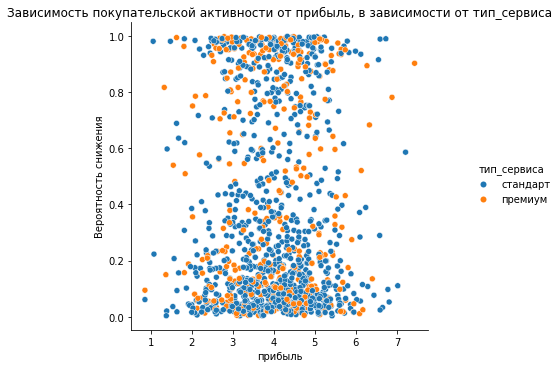

<Figure size 720x432 with 0 Axes>

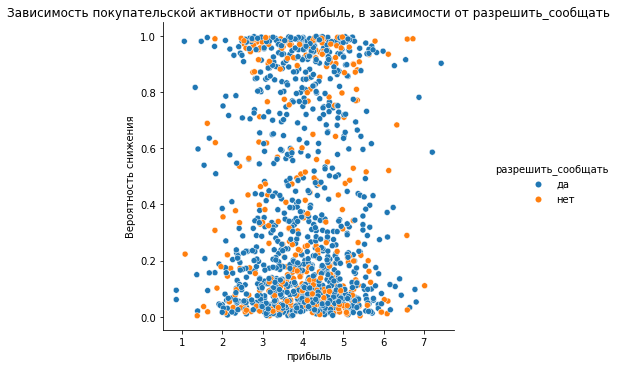

<Figure size 720x432 with 0 Axes>

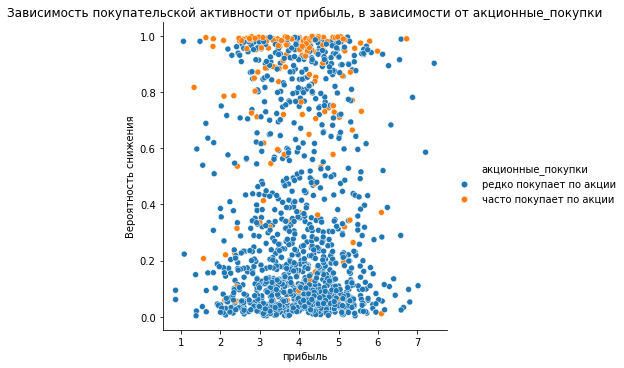

<Figure size 720x432 with 0 Axes>

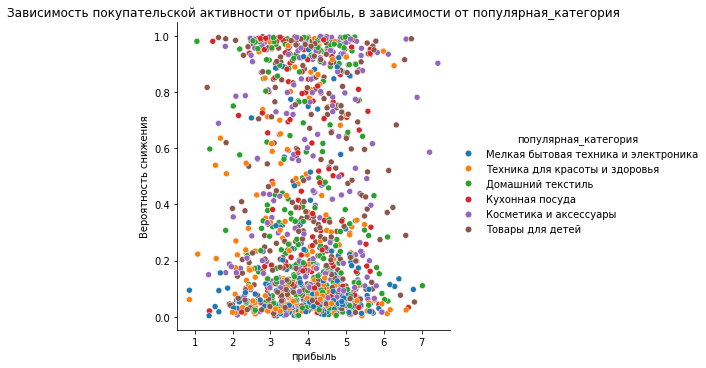

In [71]:
cat_columns = list(df_full.select_dtypes(include='object').columns)
customer_activity(df_full, 'прибыль', cat_columns)

Пользователи, которые часто покупают по скидке чаще всего имеют высокую вероятность снижения активности. Буду исследовать эту группу

In [72]:
# cоздаю новый столбец 'сегмент'
df_full['сегмент'] = 'Остальные пользователи'

# устанавливаем условия для 'Исследуемый сегмент'
df_full.loc[
    (df_full['вероятность_снижения'] > 0.8) & 
    (df_full['акционные_покупки'] == 'часто покупает по акции'), 
    'сегмент'
] = 'Исследуемый сегмент'
display(df_full.tail(5))

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,период_текущий_месяц,период_предыдущий_месяц,вероятность_снижения,прибыль,сегмент
id,,,,,,,,,,,,,,,,,,,
215568,премиум,да,4.0,5,1073,редко покупает по акции,Товары для детей,4,2,3,3,3933.4,2909.0,4740.0,10.0,10.0,0.596311,5.49,Остальные пользователи
216119,премиум,да,4.1,3,208,редко покупает по акции,Косметика и аксессуары,5,2,1,10,5004.0,5004.0,5154.0,8.0,12.0,0.190277,4.93,Остальные пользователи
215504,стандарт,да,3.4,5,458,часто покупает по акции,Товары для детей,2,4,2,2,3412.5,3432.0,4543.0,10.0,11.0,0.984855,2.08,Исследуемый сегмент
216547,стандарт,нет,4.0,3,509,редко покупает по акции,Косметика и аксессуары,2,6,3,13,4913.7,4369.0,4847.0,10.0,13.0,0.601815,3.98,Остальные пользователи
215398,премиум,да,3.5,5,882,редко покупает по акции,Мелкая бытовая техника и электроника,3,2,6,3,5854.2,5530.5,4557.0,6.0,5.0,0.890568,4.77,Остальные пользователи


In [73]:
def histogram(df, col, target):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)
    

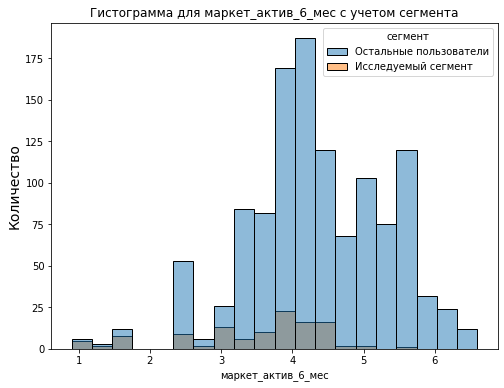

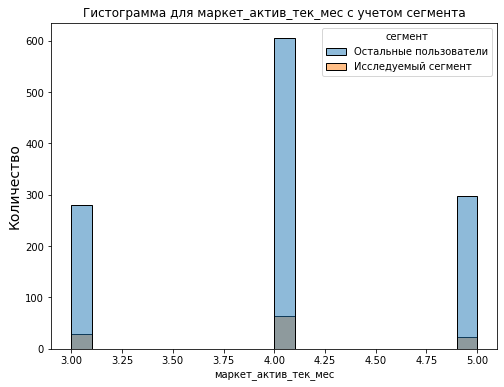

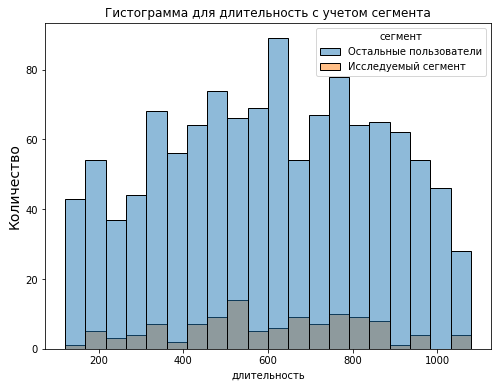

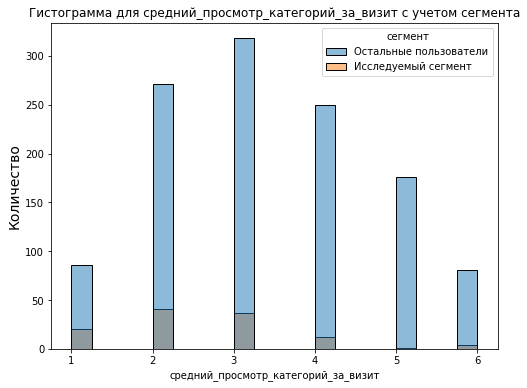

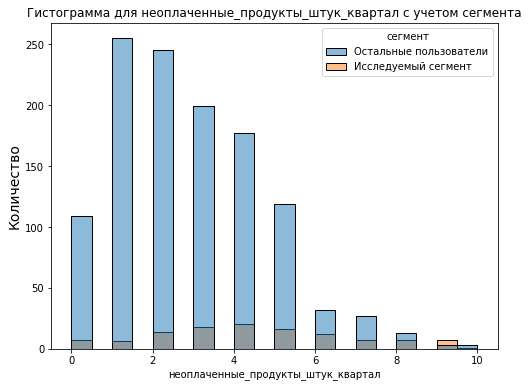

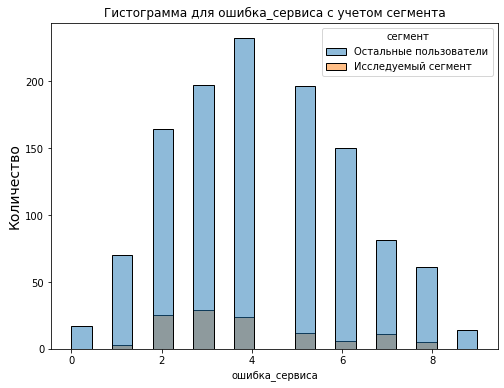

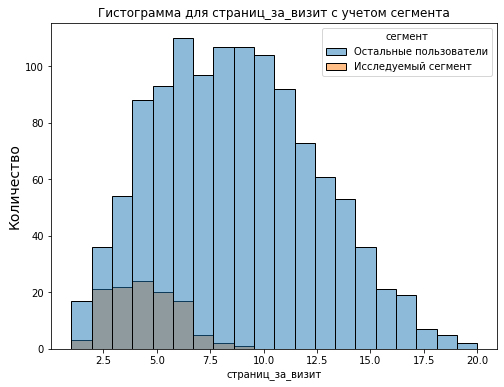

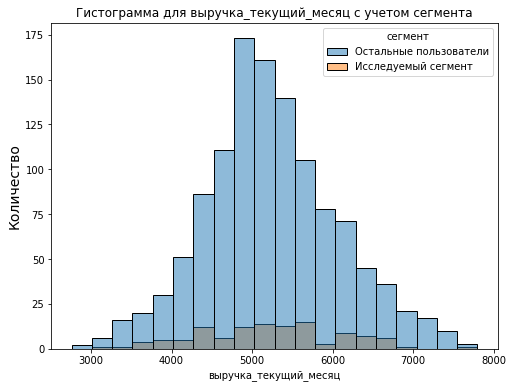

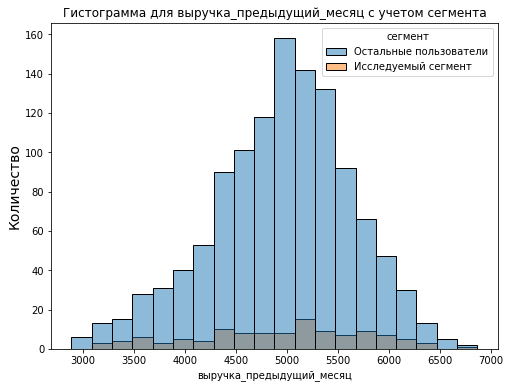

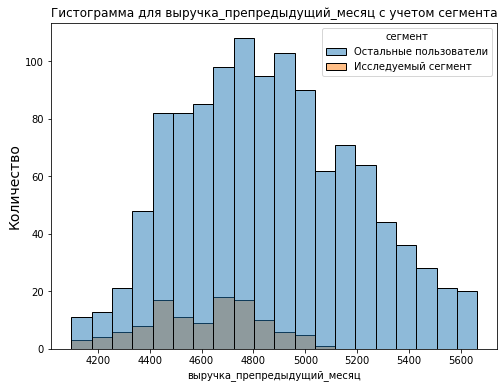

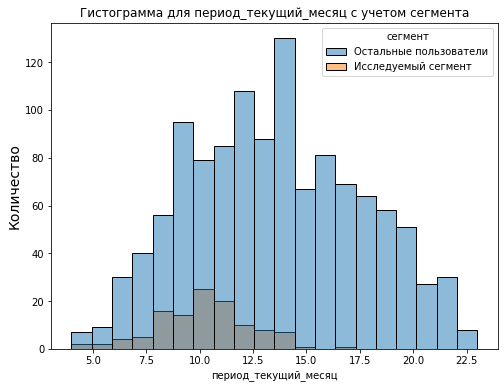

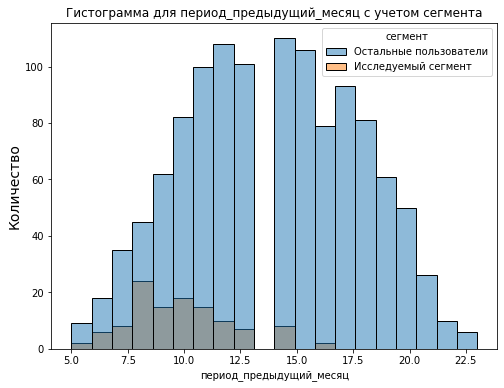

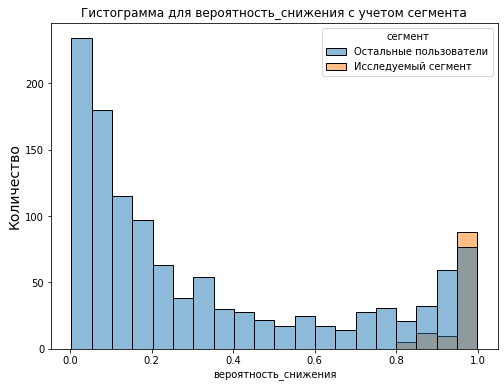

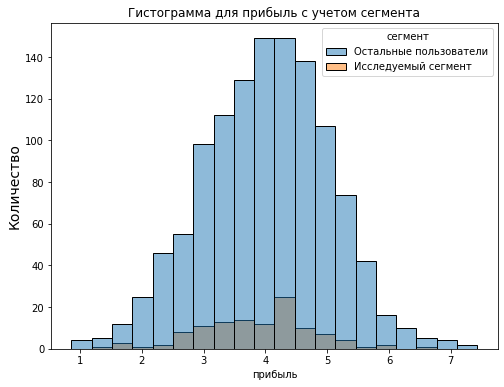

In [74]:
num_columns = list(df_full.select_dtypes(include='number').columns)
target = 'сегмент'
df = df_full

# Перебираем каждый числовой столбец и строим гистограмму
for col in num_columns:
    histogram(df, col, target)
    plt.title(f'Гистограмма для {col} с учетом сегмента')
    plt.show()  # выводит график для каждого столбца по очереди

Можно заметить, что с большинством покупателей из исследуемого сегмента потеряна маркетинговая коммуникация, на их долю последние два месяца приходится мало рассылок и звонков. Так же данный сегмент в основном просматривает мало категорий за один визит, мало страниц и проводят мало времени на сайте - они очень целенаправленно покупают. При этом пользователи из иследуемого сегмента в среднем оставляют неоплаченными в корзине больше товаров.

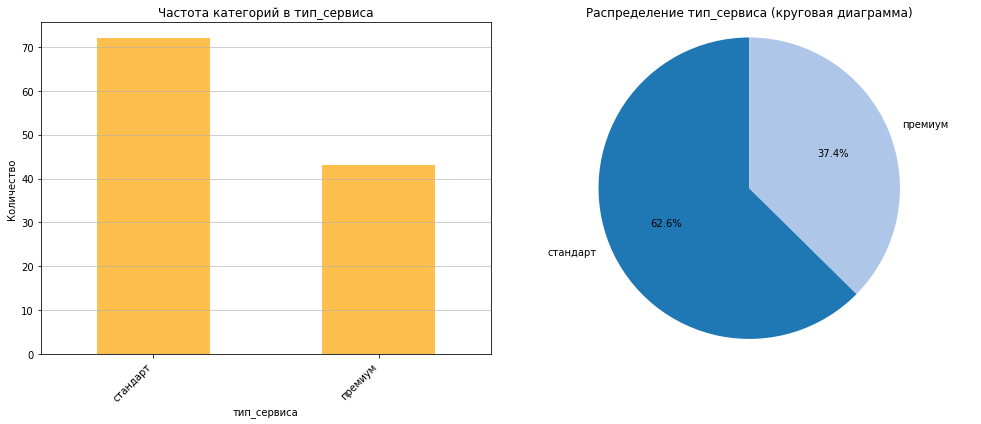

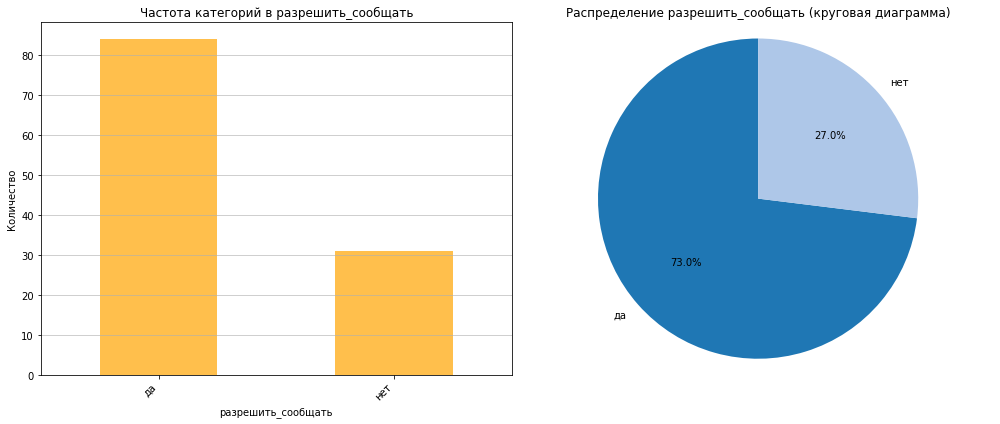

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

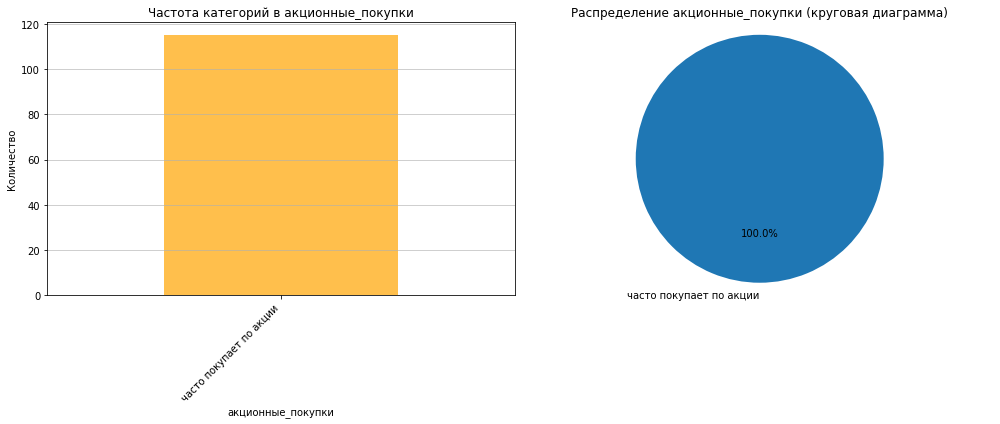

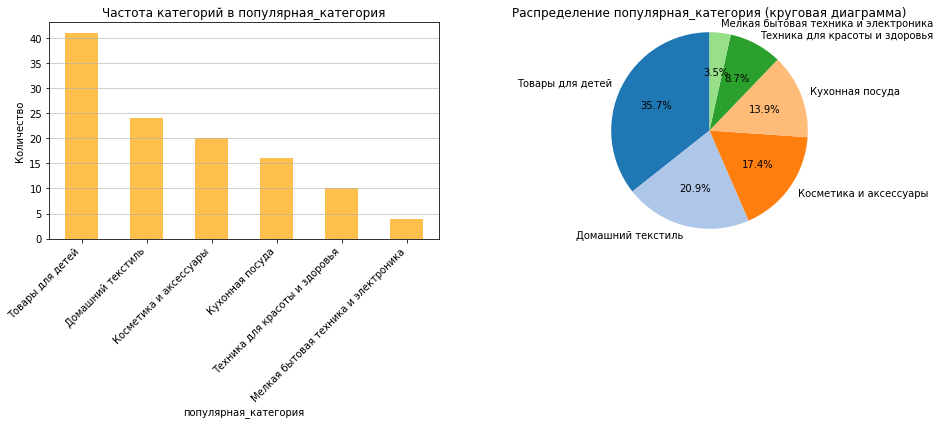

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

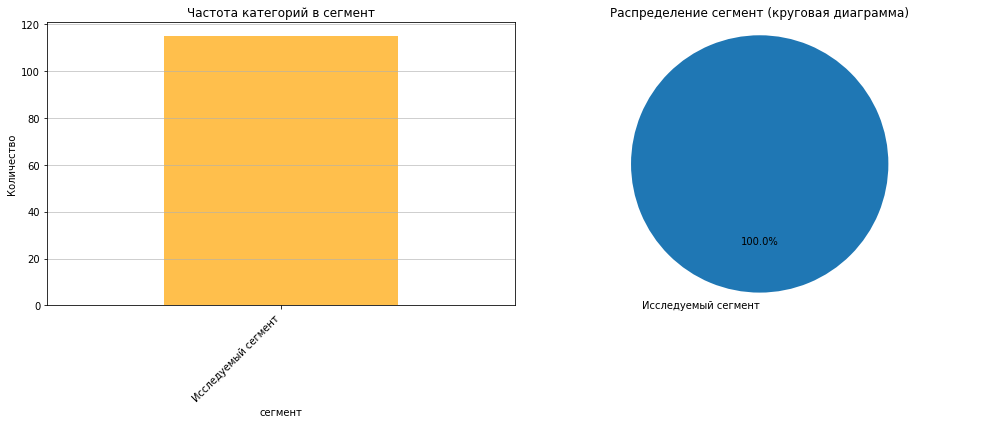

In [75]:
# визуализирую категориальные признаки df_market_file
plot_categorical_features( df_full[df_full['сегмент'] == 'Исследуемый сегмент'])

Скорее всего в этой категории много молодых мам, поскольку их интересуют товары для детей, домашний текстиль и косметика

Предложения для увеличения прибыли от покупателей в исследуемой категории:
- Увеличить количество рассылок со скидками;
- Обновлять информацию о скидках на главной странице;
- Акцентировать внимание на скидки в категориях товары для детей, домашний текстиль и косметика

Отдельно стоит отметить необходимость собирать данные по полу и возрасту покупателей, можно преподнести это под соусом "акция ко дню рождения"

**Выводы**

Во время сегменации было замечено, что пользователи, которые часто покупают по скидке чаще всего имеют высокую вероятность снижения активности. Для исследования была выбрана эта группа.

Можно заметить, что с большинством покупателей из исследуемого сегмента потеряна маркетинговая коммуникация, на их долю последние два месяца приходится мало рассылок и звонков. Так же данный сегмент в основном просматривает мало категорий за один визит, мало страниц и проводят мало времени на сайте - они очень целенаправленно покупают. При этом пользователи из иследуемого сегмента в среднем оставляют неоплаченными в корзине больше товаров.
Скорее всего в этой категории много молодых мам, поскольку их интересуют товары для детей, домашний текстиль и косметика.

Предложения для увеличения прибыли от покупателей в исследуемой категории:
- Увеличить количество рассылок со скидками;
- Обновлять информацию о скидках на главной странице;
- Акцентировать внимание на скидки в категориях товары для детей, домашний текстиль и косметика

Отдельно стоит отметить необходимость собирать данные по полу и возрасту покупателей, можно преподнести это под соусом "акция ко дню рождения"

## Общий вывод

Целью данного исследования было создание модели, способной прогнозировать снижение покупательской активности пользователей интернет-магазина "В один клик". Кроме того, важно было провести анализ выбранного сегмента пользователей.

**1. Анализ информации о данных**

1. В данных df_market_file 1300 строк. Пропуски отсутствуют. Названия некоторых столбцов содержат пробелы, что нужно будет исправить в дальнейшем
2. В данных df_market_money 3900 строк. Пропуски отсутствуют.
3. В данных df_market_time 2600 строк. Пропуски отсутствуют. В периоде есть опечатки, нужно будет исправить
4. В данных df_market_time 1300 строк. Пропуски отсутствуют


**2. Предобработка данных**

В ходе предобработки данных в датафреймах сделаны следующие преобразования:

1. Названия столбцов во всех датасетах приведены к единому формату
2. В столбцах тип_сервиса и период значения приведены к единому образцу

**3. Исследовательский анализ данных**

1. В df_market_money один выброс был заменен на медианное занчение.
2. Трое из 1300 покупателей не были активны в течение трех месяцев. Поэтому данные по ним исключены из анализа.
3. Выручка за последние три месяца примерно одинаковая
4. Большинство покупателей не ориентируются на скидки. Но часть клиентов отлеживают скидки. Поэтому подготовке данных для модели нужно превратить колонку акционные_покупки в категоральный признак.
5. Возможно, стоит поработать над стабильностью работы сайта. В среднем 4 разаза визит возникает ошибка сервиса.
6. Видно дисбаланс значений в целевом признаке, это нужно будет учесть в модели
7. Большинство клиентов (71,1%) пользуются типом сервиса стандарт
8. Самымой популярной категорией являются товары для детей, наименее популярной - кухонная посуда
9. Половина покупателей проводят на сайте от 10 до 16 минут.

**4. Объединение таблиц**

После объединения таблиц все данные находятся в одном датасете

**5. Корреляционный анализ признаков**

Целевой признак, связанный с покупательской активностью, имеет корреляцию с количеством страниц, которые клиенты просматривают за один визит, а также с временем, проведённым в предыдущем и текущем месяце. Из всех признаков наблюдается лишь одна относительно сильная корреляция между выручкой за предыдущий месяц и текущим месяцем, однако коэффициент корреляции составляет менее 0.9, что означает, что нет необходимости удалять эти признаки.

**6. Использование пайплайнов**

В результате анализа различных моделей с использованием пайплайнов наилучшей моделью оказалась линейная регрессия. Она обладает следующими характеристиками: значение параметра C равно 4, что указывает на умеренную регуляризацию — высокий параметр C позволяет модели лучше адаптироваться к данным, что в данном случае свидетельствует о относительно слабой регуляризации. Параметр penalty установлен на 'l1', что подразумевает использование L1-регуляризации, которая добавляет штраф за абсолютные значения коэффициентов модели во время процесса обучения. Это способствует отбору значимых признаков, приводя к тому, что менее важные параметры могут быть обнулены. Также фиксирован параметр random_state равным 42, что служит простой константой для обеспечения воспроизводимости результатов. Алгоритм оптимизации выбранный для обучения модели — 'liblinear', который хорошо подходит для задач двоичной классификации и эффективно справляется с средними и крупными наборами данных. Значение ROC AUC составило 0.92, что демонстрирует достаточно высокий уровень точности модели.

**7. Анализ важности признаков**

Для итоговой модели которую мы отобрали наиболее важными признаками является:
- доля акционных покупок;
- среднее кол-во просмотренных категорий за визит;
- проведенное в предыдущем и в этом месяце время;
- кол-во неоплаченных товаров в корзине за квартал.

Наименее важны оказались следующие признаки:
- выручка за текущий и предыдущий месяцы;
- популярные категории (за исключением бытовой техники и техники для красоты;
- разрешение на отправку рекламынх рассылок;
- тип сервиса;
- ошибки сервиса;
- длительность.

При принятии бизнес-решений важно учитывать поведение клиентов на сайте. Следует сосредоточиться на увеличении их вовлеченности, что включает в себя изучение времени прокрутки страниц и эффективность презентации новых категорий товаров. Организация скидок также может способствовать повышению интереса и активности пользователей.

**8. Сегментация покупателей**

Во время сегменации было замечено, что пользователи, которые часто покупают по скидке чаще всего имеют высокую вероятность снижения активности. Для исследования была выбрана эта группа.

Можно заметить, что с большинством покупателей из исследуемого сегмента потеряна маркетинговая коммуникация, на их долю последние два месяца приходится мало рассылок и звонков. Так же данный сегмент в основном просматривает мало категорий за один визит, мало страниц и проводят мало времени на сайте - они очень целенаправленно покупают. При этом пользователи из иследуемого сегмента в среднем оставляют неоплаченными в корзине больше товаров.
Скорее всего в этой категории много молодых мам, поскольку их интересуют товары для детей, домашний текстиль и косметика.


**Заключение**

Предложения для увеличения прибыли от покупателей:
- Увеличить количество рассылок со скидками;
- Обновлять информацию о скидках на главной странице;
- Акцентировать внимание на скидки в категориях товары для детей, домашний текстиль и косметика

Отдельно стоит отметить необходимость собирать данные по полу и возрасту покупателей.